
# 協調フィルタリング

協調フィルタリング（Collaborative Filtering）とは、ユーザー間で共有される嗜好性（好み）を基に、あるユーザーがまだ評価していないアイテムに対する評価を予測するための手法です。  
例えば、映画の推薦システムでは、一部のユーザーが評価した映画の評価値から、他のユーザーがまだ評価していない映画に対する評価を予測することができます。

# SVDを用いた協調フィルタリング

SVD（Singular Value Decomposition）を用いた協調フィルタリングは、行列分解の手法の一つであり、評価値の未知の部分を予測するために用いられます。 
評価行列を分解することで、ユーザーとアイテムの潜在的な特性を捉え、これを基に評価値の未知の部分を予測します。

SVDを用いた協調フィルタリングの手順は以下の通りです。

1. **行列の初期化**：評価行列を初期化します。行はユーザー、列はアイテムを表し、各要素はそのユーザーのアイテムに対する評価値を表します。評価が未知の部分はNaNや0で埋められます。
2. **行列の分解**：評価行列をSVDによって3つの行列に分解します。分解した行列はユーザーの潜在的な特性を表す行列U、アイテムの潜在的な特性を表す行列V、およびそれらの特性の重要度を表す対角行列Σです。
3. **行列の再構成**：分解した行列を元に戻すことで、評価行列の未知の部分を予測します。具体的には、行列U、Σ、Vを掛け合わせることで評価行列を再構成します。

評価行列を以下のように表すと、

$$
R = U \Sigma V^T
$$

ここで、Rは評価行列、Uはユーザーの潜在的な特性を表す行列、Σはそれらの特性の重要度を表す対角行列、Vはアイテムの潜在的な特性を表す行列です。

4. **評価値の予測**：再構成した評価行列から、評価が未知だった部分の評価値を予測します。

*written by ChatGPT

# surpriseライブラリを使用した予測

In [1]:
# !pip install scikit-surprise

### 1. Cross validationによる手法の評価

In [4]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Define a Reader object
# The Reader object helps in parsing the file or dataframe
reader = Reader(rating_scale=(1, 10))

# Load the dataset
train_df = pd.read_csv('/workspace/input/atmaCup15_dataset/train.csv')

train_data = Dataset.load_from_df(train_df[['user_id', 'anime_id', 'score']], reader)

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
_ = cross_validate(algo, train_data, measures=['RMSE',], cv=10, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2023  1.2118  1.1998  1.2104  1.2023  1.2053  0.0048  
Fit time          0.60    0.63    0.63    0.65    0.59    0.62    0.02    
Test time         0.08    0.08    0.15    0.08    0.08    0.09    0.03    


### 2. 全trainデータで学習し直す

In [6]:
# Create the dataset to be used for building the filter
train_data = Dataset.load_from_df(train_df[['user_id', 'anime_id', 'score']], reader)

# Retrieve the trainset.
train_data = train_data.build_full_trainset()

# Build an algorithm, and train it.
algo = SVD()
_ = algo.fit(train_data)

### 3. testデータに対して予測

In [9]:
# Load the test dataset
test_df = pd.read_csv('/workspace/input/atmaCup15_dataset/test.csv')
test_df['score'] = 0

# Convert the test dataset to the surprise format
test_set = Dataset.load_from_df(test_df, reader).build_full_trainset().build_testset()

# Predict ratings for the testset
predictions = algo.test(test_set)

submission = pd.read_csv('/workspace/input/atmaCup15_dataset/sample_submission.csv')

# Extract the predicted ratings and add them to the test dataframe
submission['score'] = [pred.est for pred in predictions]

submission.to_csv('submission.csv', index=False)

この例ではanime.csvの内容は全く使用せず、純粋なユーザーの評価値のみを使用しています。  
それらのデータと組み合わせることでさらに精度の向上が期待できますので、試してみてください。

<Axes: >

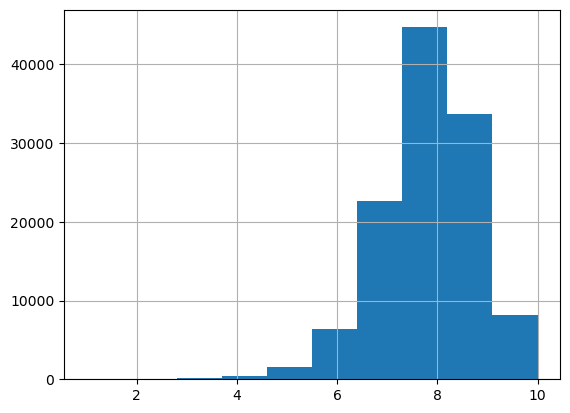

In [10]:
submission["score"].hist()